<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/lab4/lab4_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

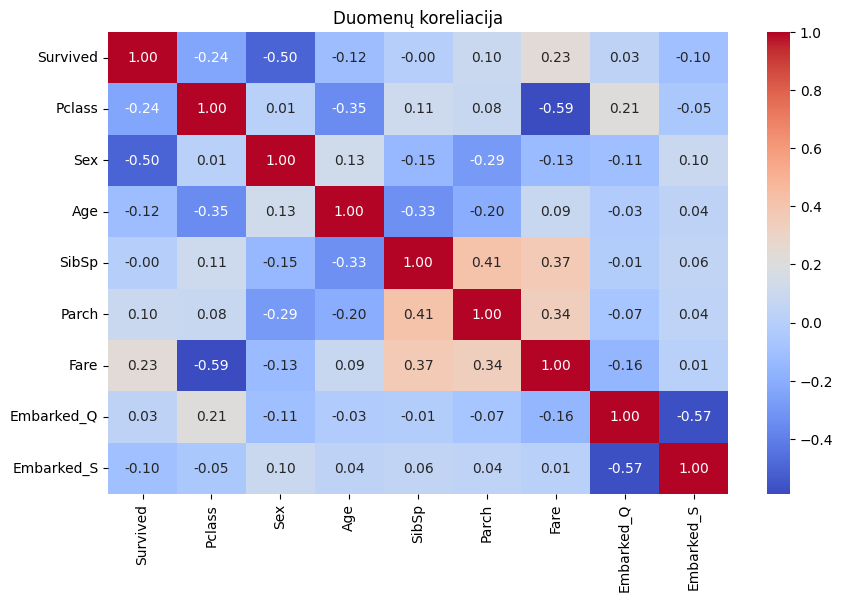

Mokymo duomenys: (620, 8)


In [1]:
# --- 1. DATA PREPARATION & EXPLORATION ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

# Įkeliame ir paruošiame duomenis (kaip Lab 1)
df = pd.read_csv('Titanic.csv')

# Valymas
imputer_age = SimpleImputer(strategy='median')
df['Age'] = imputer_age.fit_transform(df[['Age']])
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
if 'Cabin' in df.columns: df.drop('Cabin', axis=1, inplace=True)
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Kodavimas
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Išskirtys (Outliers)
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Fare'] >= (Q1 - 1.5 * IQR)) & (df['Fare'] <= (Q3 + 1.5 * IQR))]

# Vizualizacija (Exploration reikalavimas)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Duomenų koreliacija")
plt.show()

# Dalinimas ir Skalavimas
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Mokymo duomenys: {X_train_scaled.shape}")


--- Mokomas modelis: Small ---
Small Model Accuracy: 0.7355

--- Mokomas modelis: Deep ---
Deep Model Accuracy: 0.7806

--- Mokomas modelis: Regularized ---
Regularized Model Accuracy: 0.7484


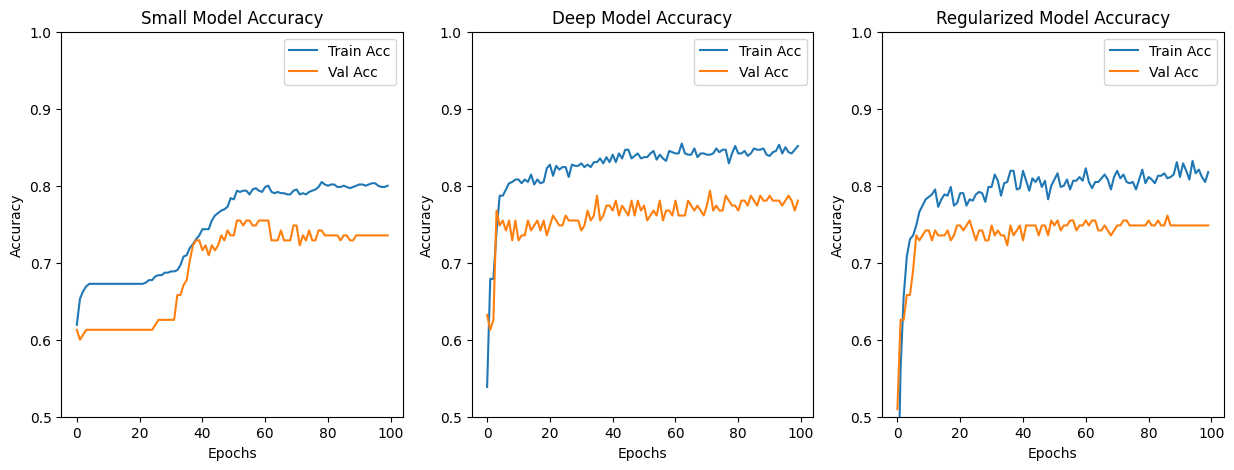

In [3]:
# --- 2. NEURAL NETWORK - 3 DIFFERENT STRUCTURES ---

def create_model(structure_type):
    model = Sequential()
    model.add(InputLayer(shape=(X_train_scaled.shape[1],)))

    if structure_type == "Small":
        # 1. Mažas tinklas (nedaug neuronų, 1 paslėptas sluoksnis)
        model.add(Dense(8, activation='relu'))

    elif structure_type == "Deep":
        # 2. Gilus tinklas (daugiau sluoksnių ir neuronų)
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))

    elif structure_type == "Regularized":
        # 3. Reguliarizuotas tinklas (su Dropout, kad išvengtų permokymo)
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3)) # Išjungia 30% neuronų atsitiktinai
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))

    # Išėjimo sluoksnis (visada vienodas binarinei klasifikacijai)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Treniruojame visus 3 modelius
structures = ["Small", "Deep", "Regularized"]
history_dict = {}
models_dict = {}

plt.figure(figsize=(15, 5))

for i, struct in enumerate(structures):
    print(f"\n--- Mokomas modelis: {struct} ---")
    model = create_model(struct)

    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test),
                        epochs=100,
                        batch_size=32,
                        verbose=0) # verbose=0 kad nešiukšlintų ekrano

    history_dict[struct] = history
    models_dict[struct] = model

    # Vertinimas
    loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"{struct} Model Accuracy: {acc:.4f}")

    # Braižome mokymosi kreives
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{struct} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.5, 1.0)

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


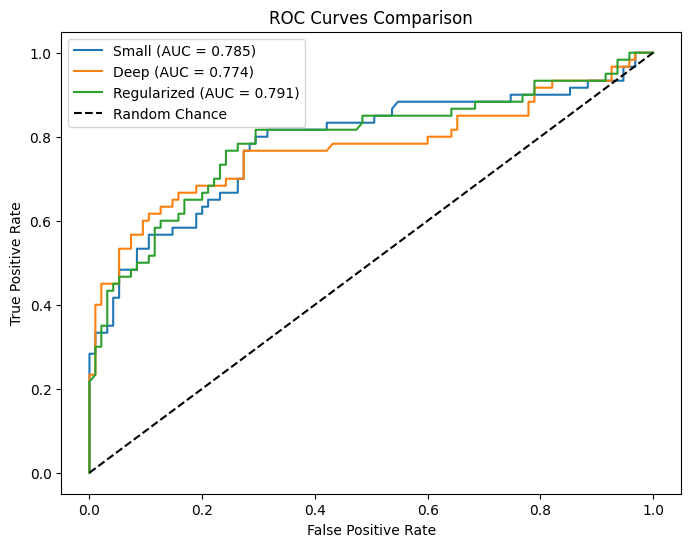

In [4]:
# --- 3. MODEL EVALUATION (ROC Curve) ---
# Reikalavimas: "at least two evaluation methods" (Accuracy jau turime, dabar ROC)

plt.figure(figsize=(8, 6))

for struct in structures:
    model = models_dict[struct]
    y_pred_prob = model.predict(X_test_scaled).ravel() # Tikimybės

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{struct} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Įstrižainė
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()